## Load libraries

In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import numpy as np
np.random.seed(37)
import pymc3 as pm
from datetime import datetime
start = datetime.now()
print('start time: {}'.format(start.strftime('%Y-%m-%d %H:%M')))
print('Running on PyMC3 v{}'.format(pm.__version__))
%matplotlib inline

start time: 2018-11-25 23:14:01
Running on PyMC3 v3.5


## Load data

Do what you gotta do to load ze data. Fill out the cell below with the labels of the two samples you are trying to compare. Ex: `before` and `after`

In [2]:
g1 = 'college_daily_steps'
g2 = 'work_daily_steps'
measure = 'Number Steps Per Day'

dict_user_group_labels = {'group1': g1,
                          'group2': g2,
                          'measure': measure}

In [3]:
df = pd.concat([pd.read_json(f) for f in glob('steps*')])

In [4]:
df.set_index('dateTime', inplace=True)

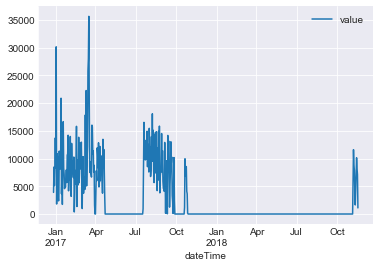

In [5]:
df.resample('1D').sum().plot()

In [6]:
df = df.resample('1D').sum()

### Pre-process

In this step I am seperating the data into the two samples I would like to compare.

In [7]:
group1 = df[(df.index >= '2016-08') & (df.index <= '2017-05')]
group2 = df[df.index >= '2018-02']

In [8]:
group1 = group1 [ group1.value > 0 ]
group2 = group2 [ group2.value > 0 ]

In [9]:
g1_len = len(group1)
g1_len

115

In [10]:
g2_len = len(group2)
g2_len

12

Before you run this block, make sure you have two different sample groups to compare. Using a bayesian t test will communicate the difference in sample mean and standard deviation for two different groups.

When combined with a boxplot and or a categorical-colored histogram, this test communicates uncertainty about the sample mean difference calculation.

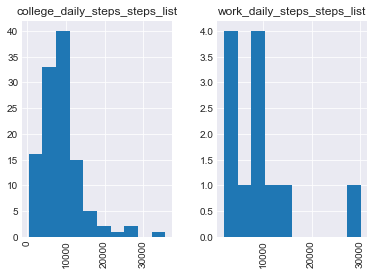

In [11]:
group2_steps_list = group2.value.tolist()
group1_steps_list = group1.value.tolist()

y1 = np.array(group1_steps_list)
y2 = np.array(group2_steps_list)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['{}_steps_list'.format(dict_user_group_labels['group2'])]*len(group2_steps_list),
                                                       ['{}_steps_list'.format(dict_user_group_labels['group1'])]*len(group1_steps_list)]))

y.hist('value', by='group');

In [12]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('{}_mean'.format(dict_user_group_labels['group1']), μ_m, sd=μ_s)
    group2_mean = pm.Normal('{}_mean'.format(dict_user_group_labels['group2']), μ_m, sd=μ_s)

In [13]:
σ_low = 80
σ_high = 100

with model:
    group1_std = pm.Uniform('{}_std'.format(dict_user_group_labels['group1']), lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('{}_std'.format(dict_user_group_labels['group2']), lower=σ_low, upper=σ_high)

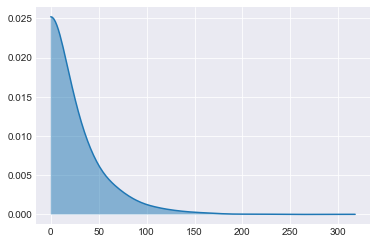

In [14]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), shade=0.5);

In [15]:
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('{}'.format(dict_user_group_labels['group2']), nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('{}'.format(dict_user_group_labels['group1']), nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [16]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [17]:
with model:
    trace = pm.sample(10000, cores=2, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, work_daily_steps_std, college_daily_steps_std, work_daily_steps_mean, college_daily_steps_mean]
Sampling 2 chains: 100%|██████████| 24000/24000 [02:45<00:00, 145.32draws/s]
The acceptance probability does not match the target. It is 0.5942993037267583, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [18]:
plot_time = datetime.now()
print('plot time: {}'.format(plot_time.strftime('%Y-%m-%d %H:%M')))
model_hours, remainder = divmod((plot_time - start).total_seconds(), 3600)
model_minutes, model_seconds = divmod(remainder, 60)

plot time: 2018-11-25 23:19


In [19]:
print('model took {} hours, {} minutes, and {} seconds to run'.format(round(model_hours),
                                                                      round(model_minutes),
                                                                      round(model_seconds)))

model took 0 hours, 5 minutes, and 2 seconds to run


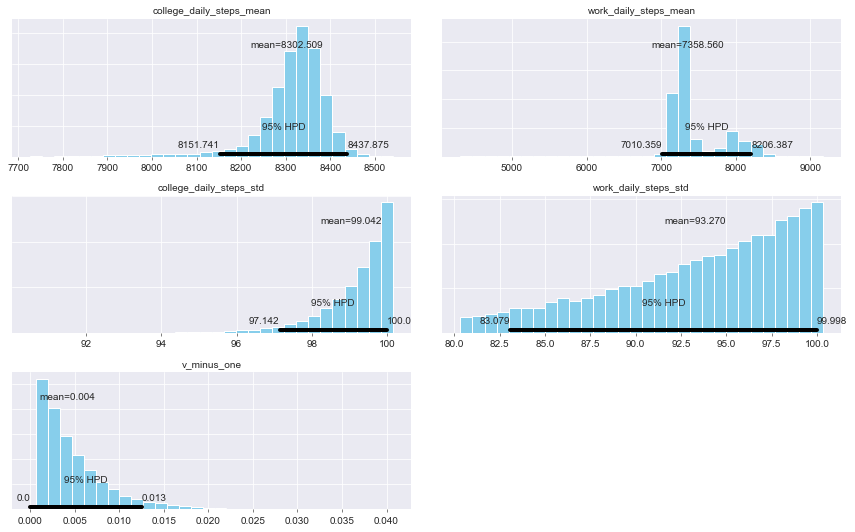

In [20]:
pm.plot_posterior(trace, varnames=['{}_mean'.format(dict_user_group_labels['group1']),
                                   '{}_mean'.format(dict_user_group_labels['group2']),
                                   '{}_std'.format(dict_user_group_labels['group1']),
                                   '{}_std'.format(dict_user_group_labels['group2']),
                                   'ν_minus_one'],
                  color='#87ceeb');
plt.savefig('Bayesian t-test {} {} {} Comparison of Mean and std {}.png'.format(dict_user_group_labels['group1'],
                                                                                dict_user_group_labels['group2'],
                                                                                dict_user_group_labels['measure'],
                                                                                plot_time.strftime('%Y-%m-%d %H:%M')))

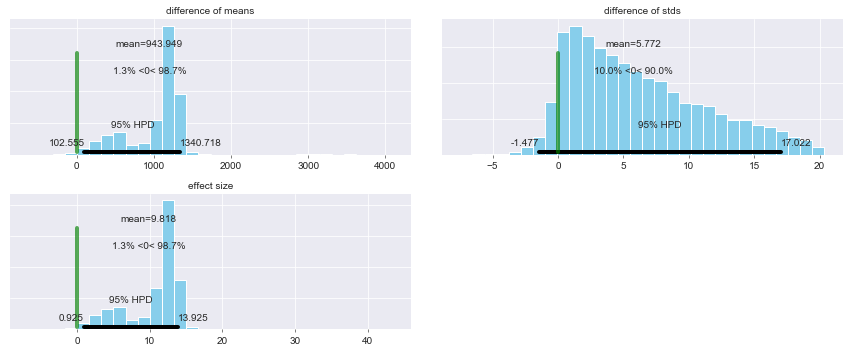

In [21]:
pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')
plt.savefig('Bayesian t-test {} {} {} Difference in Mean and std {}.png'.format(dict_user_group_labels['group1'],
                                                                                dict_user_group_labels['group2'],
                                                                                dict_user_group_labels['measure'],
                                                                                plot_time.strftime('%Y-%m-%d %H:%M')))

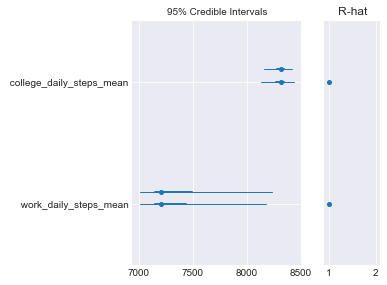

In [22]:
pm.forestplot(trace, varnames=['{}_mean'.format(dict_user_group_labels['group1']),
                               '{}_mean'.format(dict_user_group_labels['group2'])])
plt.savefig('Bayesian t-test {} {} {} Mean Forestplot {}.png'.format(dict_user_group_labels['group1'],
                                                                                dict_user_group_labels['group2'],
                                                                                dict_user_group_labels['measure'],
                                                                                plot_time.strftime('%Y-%m-%d %H:%M')))

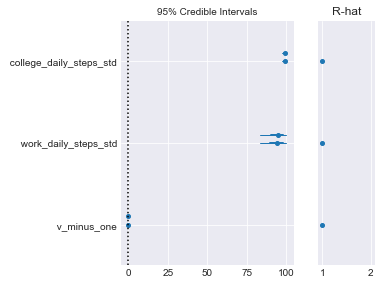

In [23]:
pm.forestplot(trace, varnames=['{}_std'.format(dict_user_group_labels['group1']),
                               '{}_std'.format(dict_user_group_labels['group2']),
                               'ν_minus_one'])
plt.savefig('Bayesian t-test {} {} {} std Forestplot {}.png'.format(dict_user_group_labels['group1'],
                                                                                dict_user_group_labels['group2'],
                                                                                dict_user_group_labels['measure'],
                                                                                plot_time.strftime('%Y-%m-%d %H:%M')))

In [24]:
summary = pm.summary(trace,varnames=['difference of means', 'difference of stds', 'effect size'])
summary.to_csv('Bayesian t-test {} {} {} Difference in Mean and std Results {}.csv'.format(dict_user_group_labels['group1'],
                                                                                dict_user_group_labels['group2'],
                                                                                dict_user_group_labels['measure'],
                                                                                plot_time.strftime('%Y-%m-%d %H:%M')))
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference of means,943.948749,404.035236,18.742385,102.554762,1340.718159,472.510769,1.000950
difference of stds,5.772260,5.196893,0.046676,-1.476502,17.022303,9202.638967,1.000151
effect size,9.818402,4.211211,0.194370,0.924595,13.925253,478.456849,1.000891


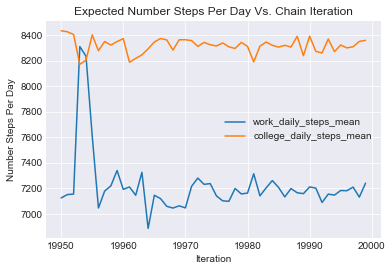

In [25]:
pd.Series(trace['{}_mean'.format(dict_user_group_labels['group2'])])[-50:].plot(label='{}_mean'.format(dict_user_group_labels['group2']))
pd.Series(trace['{}_mean'.format(dict_user_group_labels['group1'])])[-50:].plot(label='{}_mean'.format(dict_user_group_labels['group1']))
plt.ylabel(measure)
plt.xlabel('Iteration')
title = 'Expected {} Vs. Chain Iteration'.format(dict_user_group_labels['measure'])
plt.title(title)
plt.legend()
plt.savefig('Bayesian t-test {} {} {} {} {}.png'.format(dict_user_group_labels['group1'],
                                                                                dict_user_group_labels['group2'],
                                                                                dict_user_group_labels['measure'],
                                                                                title,
                                                                                plot_time.strftime('%Y-%m-%d %H:%M')))

In [48]:
df_bayesian_test_results = pd.DataFrame({'1_{}_posterior_mean'.format(dict_user_group_labels['group1']):trace['{}_mean'.format(dict_user_group_labels['group1'])],
              '2_{}_posterior_mean'.format(dict_user_group_labels['group2']):trace['{}_mean'.format(dict_user_group_labels['group2'])],
              '3_{}_posterior_std'.format(dict_user_group_labels['group1']):trace['{}_std'.format(dict_user_group_labels['group1'])],
              '4_{}_posterior_std'.format(dict_user_group_labels['group2']):trace['{}_std'.format(dict_user_group_labels['group2'])],
              '5_difference_of_means': trace['difference of means'],
              '6_difference_in_std': trace['difference of stds'],
              '7_effect_size': trace['effect size']})
df_bayesian_test_results.head()

,1_college_daily_steps_posterior_mean,2_work_daily_steps_posterior_mean,3_college_daily_steps_posterior_std,4_work_daily_steps_posterior_std,5_difference_of_means,6_difference_in_std,7_effect_size
0,8216.496975,7475.324546,99.228767,96.757758,741.172428,2.471009,7.562903
1,8207.325453,7229.464184,98.712956,97.303213,977.861269,1.409743,9.977095
2,8445.567313,7120.980386,99.309254,94.729566,1324.586927,4.579688,13.649002
3,8445.567313,7120.980386,99.309254,94.729566,1324.586927,4.579688,13.649002
4,8315.726127,7320.775976,99.460332,94.916438,994.950151,4.543893,10.234540


In [49]:
df_bayesian_test_results.to_csv('Bayesian_t-test_Difference_in_Means_{}_{}_Results_{}.csv'.format(dict_user_group_labels['group1'],
                                                                                dict_user_group_labels['group2'],
                                                                                dict_user_group_labels['measure'],
                                                                                plot_time.strftime('%Y-%m-%d_%H:%M')))

## Write Log

In [29]:
end = datetime.now()

In [30]:
with open("log_{}.txt".format(start.strftime('%Y-%m-%d %H:%M')), "w", newline='\n') as text_file:
    text_file.write('Model Start Time: {}'.format(start.strftime('%Y-%m-%d %H:%M')))
    text_file.write('Measuring the {}'.format(dict_user_group_labels['measure']))
    text_file.write('{} had {} observations'.format(dict_user_group_labels['group1'], g1_len))
    text_file.write('{} had {} observations'.format(dict_user_group_labels['group2'], g2_len))
    text_file.write('bayesian model took {} hours, {} minutes, and {} seconds to run'.format(round(model_hours),
                                                                      round(model_minutes),
                                                                      round(model_seconds)))
    text_file.write('Model End Time: {}'.format(end.strftime('%Y-%m-%d %H:%M')))